# NFL Data Analysis

## Executive Summary and Objective

Our goal is to analyze the correlation between a players first season with a team (whether its their first rookie season or first season with a new team) and their contract value. In order to do this, we merged two datasets: NFL Stats 2012-2024 (to have the players statistics) and NFL Contract and Draft Data (to have the players contract value). The NFL Stats 2012-2024 has each observation as one player's average performance in one regular season, while NFL Contract and Draft Data has each observation as one contract a specific player signs with a team. The goal is to merge the dataset into having one player's average performance in a season augmented with that player's contract and draft information relevant to that season.

Since we augmented our data with player's contracts, we want to find correlations between the players performance and the total cost of the contracts, and other metrics that connect their statistics on the field with financial metrics. since a player does not sing a contract every season, we would do a right join, to only have the seasons where a player singed a contract. If we were to do a left join, then we would have a vast amount of null values, and this merge is the one that makes the most sense for this augmentation.

Because the two datasets cover different time ranges (contracts from 2000–2023 and NFL stats from 2012–2024), we restrict our analysis to the overlapping years 2012–2023. Based on the Kaggle documentation, the contract dataset contains 9,387 rows in this period (2012-2023), so we expect the merged dataset to also have 9,387 rows (one per contract record), assuming all rows match successfully. However, as we are excluding the defensive players from the analysis, we have around 4,000 column to work with.

The NFL stats dataset initially includes over 100 columns, many of which capture rare or highly specific events that are not ideal for summarizing overall offensive performance. We therefore filter these down to a smaller set of core offensive stats, but we still utilize a lot of different offensive metrics. The contract dataset also has a limited set of key columns, including the join variables we use to merge the two sources. In the final merged dataset, we keep the selected columns from the NFL stats data plus the selected columns from the contract data, minus any duplicated join columns. This leaves us with a clean table of around 1,000 rows.

## Data Preparation

### NFL Stats 2012-2024 Data Cleaning

We inspect the dataset to understand our data better

In [1]:
import pandas as pd
import numpy as np

season_df = pd.read_csv("weekly_player_stats_offense.csv")
season_df

,season,week,offense_snaps,offense_pct,team_offense_snaps,player_id,birth_year,draft_year,draft_round,draft_pick,...,career_rush_td_pct,career_ypc,career_td_pct,career_yptouch,career_pass_ypg,career_rec_ypg,career_rush_ypg,career_ypg,career_average_ppr_ppg,career_average_standard_ppg
0,2012,12,63.0,1.00,63.0,00-0000865,1974,1998.0,2.0,30.0,...,NaN,NaN,0.00,6.42,199.0,0.00,0.00,199.00,1.96,1.96
1,2012,13,66.0,1.00,66.0,00-0000865,1974,1998.0,2.0,30.0,...,NaN,NaN,0.02,7.20,237.5,0.00,0.00,118.75,8.50,8.50
2,2012,2,12.0,0.18,67.0,00-0004541,1975,1999.0,7.0,7.0,...,NaN,NaN,2.00,26.00,0.0,26.00,0.00,26.00,9.60,8.60
3,2012,3,4.0,0.05,80.0,00-0004541,1975,1999.0,7.0,7.0,...,NaN,NaN,2.00,26.00,0.0,13.00,0.00,6.50,4.80,4.30
4,2012,4,18.0,0.26,69.0,00-0004541,1975,1999.0,7.0,7.0,...,NaN,NaN,1.00,14.43,0.0,9.67,0.00,3.22,3.63,2.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58624,2024,10,16.0,0.27,59.0,00-0039921,2002,2024.0,3.0,2.0,...,0.020,4.41,0.02,5.02,0.0,6.88,27.00,4.24,4.76,4.14
58625,2024,12,9.0,0.16,56.0,00-0039921,2002,2024.0,3.0,2.0,...,0.019,4.42,0.02,4.99,0.0,6.11,26.00,3.57,4.43,3.88
58626,2024,13,13.0,0.16,81.0,00-0039921,2002,2024.0,3.0,2.0,...,0.018,4.54,0.02,5.07,0.0,5.50,25.40,3.09,4.19,3.69
58627,2024,14,10.0,0.14,71.0,00-0039921,2002,2024.0,3.0,2.0,...,0.017,4.64,0.02,5.12,0.0,5.36,24.45,2.71,4.07,3.53


In order to cut down the over 300 column dataset, we first convert zeros into null values (to conduct column removal), and remove the columns that have more than 90% null values. This is because there are statistics recorder for something such as tackles, which for offensive players, this occurs less than 3 times a season on average, so it would add information we would not be using. Then, we remove the columns that include "average", "delta", "career" and "season", as these are several columns that have manipulated data, which we wont be using as we would be performing most of this aggregating through the augmented join. We are left with around 50 columns, which we manually inspect.

In [2]:
season_df = season_df.replace(0, pd.NA)
null_ratio = season_df.isna().mean()
cols_to_drop = null_ratio[null_ratio > 0.9].index
season_df = season_df.drop(columns=cols_to_drop)
words = ["average", "delta", "career","season_"]
season_df = season_df.drop(columns=[
    col for col in season_df.columns
    if any(w in col.lower() for w in words)
])
len(season_df.columns)
season_df.columns.tolist()

['season',
 'week',
 'offense_snaps',
 'offense_pct',
 'team_offense_snaps',
 'player_id',
 'birth_year',
 'draft_year',
 'draft_round',
 'draft_pick',
 'draft_ovr',
 'height',
 'weight',
 'college',
 'player_name',
 'position',
 'depth_team',
 'conference',
 'division',
 'team',
 'shotgun',
 'no_huddle',
 'qb_dropback',
 'pass_attempts',
 'complete_pass',
 'incomplete_pass',
 'passing_yards',
 'receiving_yards',
 'yards_after_catch',
 'rush_attempts',
 'rushing_yards',
 'tackled_for_loss',
 'first_down_pass',
 'first_down_rush',
 'third_down_converted',
 'third_down_failed',
 'pass_touchdown',
 'interception',
 'receptions',
 'targets',
 'passing_air_yards',
 'receiving_air_yards',
 'receiving_touchdown',
 'pass_attempts_redzone',
 'complete_pass_redzone',
 'receptions_redzone',
 'targets_redzone',
 'receiving_touchdown_redzone',
 'rush_attempts_redzone',
 'fantasy_points_ppr',
 'fantasy_points_standard',
 'passer_rating',
 'adot',
 'comp_pct',
 'ypa',
 'rec_td_pct',
 'yptarget',
 'ay

We ensure that we convert the null values back to zeros, as keeping the values as nulls would make the averages be unaffected, when in reality the player did compute 0 for a certain stat. We also separate the columns that we would be keeping after the manual inspection. while some columns hold several missing values, these provide a lot of interesting perspectives on how player performance differed over different position. 

In [3]:
season_df = season_df.fillna(0)

cols_to_keep = [
    "player_id", "player_name", "week", "season", "offense_snaps", "draft_year",
    "draft_round", "draft_pick", "draft_ovr", "height", "weight",
    "college", "position", "conference", "division", "team",
    "pass_attempts", "complete_pass", "incomplete_pass", "passing_yards",
    "receiving_yards", "yards_after_catch", "rush_attempts", "rushing_yards",
    "first_down_pass", "first_down_rush", "third_down_converted",
    "third_down_failed", "pass_touchdown", "interception", "receptions",
    "targets", "passing_air_yards", "receiving_air_yards",
    "receiving_touchdown", "pass_attempts_redzone",
    "complete_pass_redzone", "receptions_redzone", "targets_redzone",
    "receiving_touchdown_redzone", "rush_attempts_redzone",
    "fantasy_points_ppr", "fantasy_points_standard", "passer_rating",
    "adot", "comp_pct", "ypa", "rec_td_pct", "yptarget", "ayptarget",
    "ypr", "ypc", "touches", "total_tds", "td_pct", "total_yards",
    "yptouch", "age", "years_exp", "team_targets_share",
    "team_receptions_share", "team_receiving_yards_share",
    "team_receiving_air_yards_share", "team_receiving_touchdown_share",
    "team_rush_attempts_share", "team_rushing_yards_share"
]

season_df = season_df[cols_to_keep]

season_df

,player_id,player_name,week,season,offense_snaps,draft_year,draft_round,draft_pick,draft_ovr,height,...,yptouch,age,years_exp,team_targets_share,team_receptions_share,team_receiving_yards_share,team_receiving_air_yards_share,team_receiving_touchdown_share,team_rush_attempts_share,team_rushing_yards_share
0,00-0000865,Charlie Batch,12,2012,63.0,1998.0,2.0,30.0,60.0,74.0,...,6.42,37.0,14.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000
1,00-0000865,Charlie Batch,13,2012,66.0,1998.0,2.0,30.0,60.0,74.0,...,7.89,37.0,14.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000
2,00-0004541,Donald Driver,2,2012,12.0,1999.0,7.0,7.0,213.0,72.0,...,26.00,37.0,13.0,0.0370,0.0526,0.1327,0.1017,1.0,0.0000,0.0000
3,00-0004541,Donald Driver,3,2012,4.0,1999.0,7.0,7.0,213.0,72.0,...,0.00,37.0,13.0,0.0294,0.0000,0.0000,0.0543,0.0,0.0000,0.0000
4,00-0004541,Donald Driver,4,2012,18.0,1999.0,7.0,7.0,213.0,72.0,...,3.00,37.0,13.0,0.0513,0.0333,0.0099,0.0438,0.0,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58624,00-0039921,Trey Benson,10,2024,16.0,2024.0,3.0,2.0,66.0,72.0,...,7.25,22.0,0.0,0.0833,0.0909,0.0940,-0.0721,0.0,0.3125,0.4218
58625,00-0039921,Trey Benson,12,2024,9.0,2024.0,3.0,2.0,66.0,72.0,...,4.50,22.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.2857,0.3673
58626,00-0039921,Trey Benson,13,2024,13.0,2024.0,3.0,2.0,66.0,72.0,...,6.67,22.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0968,0.1299
58627,00-0039921,Trey Benson,14,2024,10.0,2024.0,3.0,2.0,66.0,72.0,...,6.33,22.0,0.0,0.0278,0.0400,0.0154,-0.0318,0.0,0.0833,0.1240


Since we want a dataset of the seasonal performance, then we make all columns be defined as average through a function in Python, allowing us to connect it with contracts. We can then see the players' seasonal performance for the first year the contract took place, whether it be their rookie contracts in the NFL, a restructured deal, or a first contract for a new team. We also ensure consistency, and since there wont be any contracts considered for 2023 (as some contracts cutoffs may be on middle of 2023), we ensure consistency among the datasets.

In [4]:
avg_cols = [
    "pass_attempts", "complete_pass", "incomplete_pass", "passing_yards",
    "receiving_yards", "yards_after_catch", "rush_attempts", "rushing_yards",
    "first_down_pass", "first_down_rush", "third_down_converted",
    "third_down_failed", "pass_touchdown", "interception", "receptions",
    "targets", "passing_air_yards", "receiving_air_yards",
    "receiving_touchdown", "pass_attempts_redzone",
    "complete_pass_redzone", "receptions_redzone", "targets_redzone",
    "receiving_touchdown_redzone", "rush_attempts_redzone",
    "fantasy_points_ppr", "fantasy_points_standard", "passer_rating",
    "adot", "comp_pct", "ypa", "rec_td_pct", "yptarget", "ayptarget",
    "ypr", "ypc", "touches", "total_tds", "td_pct", "total_yards",
    "yptouch", "years_exp", "team_targets_share",
    "team_receptions_share", "team_receiving_yards_share",
    "team_receiving_air_yards_share", "team_receiving_touchdown_share",
    "team_rush_attempts_share", "team_rushing_yards_share"
]

group_cols = ["player_name", "season"]  

agg_dict = {col: "mean" for col in avg_cols}

num_cols = season_df.select_dtypes(include="number").columns
other_num = num_cols.difference(avg_cols + group_cols)
for col in other_num:
    agg_dict[col] = "first"

non_num_cols = season_df.columns.difference(avg_cols + group_cols + list(other_num))
for col in non_num_cols:
    agg_dict[col] = "first"

season_df = (
    season_df
    .groupby(group_cols, as_index=False)
    .agg(agg_dict)
)

season_df = season_df[
    (season_df["season"] >= 2012) &
    (season_df["season"] < 2023)
]
season_df

,player_name,season,pass_attempts,complete_pass,incomplete_pass,passing_yards,receiving_yards,yards_after_catch,rush_attempts,rushing_yards,...,height,offense_snaps,week,weight,college,conference,division,player_id,position,team
1,A.J. Brown,2019,0.000000,0.000000,0.000000,0.000000,61.722222,27.666667,0.222222,3.833333,...,73.0,25.0,1,226.0,Mississippi,AFC,South,00-0035676,WR,TEN
2,A.J. Brown,2020,0.000000,0.000000,0.000000,0.000000,76.785714,30.857143,0.000000,0.000000,...,73.0,66.0,1,226.0,Mississippi,AFC,South,00-0035676,WR,TEN
3,A.J. Brown,2021,0.083333,0.000000,0.083333,0.000000,68.750000,18.083333,0.166667,0.833333,...,73.0,52.0,1,226.0,Mississippi,AFC,South,00-0035676,WR,TEN
4,A.J. Brown,2022,0.000000,0.000000,0.000000,0.000000,82.100000,30.150000,0.000000,0.000000,...,73.0,67.0,1,226.0,Mississippi,NFC,East,00-0035676,WR,PHI
7,A.J. Derby,2016,0.000000,0.000000,0.000000,0.000000,26.666667,8.333333,0.000000,0.000000,...,77.0,6.0,9,240.0,Arkansas,AFC,West,00-0031609,TE,DEN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6007,Zay Jones,2019,0.000000,0.000000,0.000000,0.000000,15.428571,5.500000,0.071429,0.214286,...,74.0,29.0,1,200.0,East Carolina,AFC,East,00-0033891,WR,BUF
6008,Zay Jones,2020,0.090909,0.090909,0.000000,2.636364,14.000000,6.181818,0.000000,0.000000,...,74.0,18.0,2,200.0,East Carolina,AFC,West,00-0033891,WR,LV
6009,Zay Jones,2021,0.000000,0.000000,0.000000,0.000000,36.400000,11.333333,0.133333,0.200000,...,74.0,20.0,1,200.0,East Carolina,AFC,West,00-0033891,WR,LV
6010,Zay Jones,2022,0.000000,0.000000,0.000000,0.000000,53.941176,18.529412,0.235294,1.058824,...,74.0,58.0,1,200.0,East Carolina,AFC,South,00-0033891,WR,JAX


Throughout this whole process, we verify statistics through online searches, for example revising if the average of 40 passing attempts for Tom Brady on the 2012 season is consistent with statistics that are available on the web. This was our way to validate that the dataset included current information. We are left with a dataset with around 5,005 rows, however we understand that this includes several rows that we will not be using after the merge. 

### NFL Contracts 2000-2022 Data Cleaning

We inspect the dataset to understand our data better

In [5]:
df_contract = pd.read_csv("combined_data_2000-2023.csv")
df_contract

,draft_year,rnd,pick,tm,player,pos,g,search_key,id,year_signed,signing_tm,value,value_norm,gtd,gtd_norm
0,2000,1.0,1.0,CLE,Courtney Brown,DE,61.0,"Courtney Brown, DE",0,2000.0,Browns,44939436.0,0.722824,10880250.0,0.175002
1,2000,1.0,1.0,CLE,Courtney Brown,DE,61.0,"Courtney Brown, DE",0,2004.0,Browns,14700000.0,0.182423,2000000.0,0.024819
2,2000,1.0,1.0,CLE,Courtney Brown,DE,61.0,"Courtney Brown, DE",0,2003.0,Browns,20500000.0,0.273308,1000000.0,0.013332
3,2000,1.0,1.0,CLE,Courtney Brown,DE,61.0,"Courtney Brown, DE",0,2005.0,Broncos,18800000.0,0.219883,1260000.0,0.014737
4,2000,1.0,1.0,CLE,Courtney Brown,DE,61.0,"Courtney Brown, DE",0,2006.0,Broncos,5400000.0,0.052941,1055000.0,0.010343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12624,2022,7.0,259.0,KAN,Nazeeh Johnson,SAF,11.0,"Nazeeh Johnson, SAF",5328,2022.0,Chiefs,3737012.0,0.017949,77012.0,0.000370
12625,2022,7.0,259.0,KAN,Nazeeh Johnson,SAF,11.0,"Nazeeh Johnson, SAF",5328,2022.0,Chiefs,1575000.0,0.007565,0.0,0.000000
12626,2022,7.0,259.0,KAN,Nazeeh Johnson,SAF,11.0,"Nazeeh Johnson, SAF",5328,2022.0,Chiefs,207000.0,0.000994,0.0,0.000000
12627,2022,7.0,260.0,LAC,Zander Horvath,RB,15.0,"Zander Horvath, RB",5329,2022.0,Chargers,3737012.0,0.017949,77012.0,0.000370


We see that in our data we have information regarding the team signing, the value, the guaranteed value (which means how much money a player is guaranteed to make with the contract), the normalized values, and some other information that overlaps (position, draft year, and so on). We remove the columns that are redundant (as they already appear in the other dataset). Additionally, since the contract data ranges since 2000, we would have to remove a lot of data that will not be merged to avoid missing values (all data previous to 2012). We do this first before any further steps. We also remove all defensive positions from the list. Additionally, we verify the data's source dictionary, to remove columns such as "tm" which are irrelevant to our research and might cause confusion (for example, tm is the team a player got drafted on, so it might mislead someone into believing its their current team). Finally, we keep the offensive positions, to match with our research question.

In [6]:
df_contract = df_contract[
    (df_contract["year_signed"] >= 2012) &
    (df_contract["year_signed"] < 2023)
]

cols_to_keep = [
    "player","pos", "g", "search_key", "year_signed",
    "signing_tm", "value", "value_norm", "gtd", "gtd_norm"
]

df_contract = df_contract[cols_to_keep]

offense_positions = ["QB", "RB", "WR"]

df_contract = df_contract[df_contract["pos"].isin(offense_positions)]

df_contract

,player,pos,g,search_key,year_signed,signing_tm,value,value_norm,gtd,gtd_norm
21,Tom Brady,QB,335.0,"Tom Brady, QB",2021.0,Buccaneers,25000000.0,0.136986,25000000.0,0.136986
22,Tom Brady,QB,335.0,"Tom Brady, QB",2016.0,Patriots,41000000.0,0.264056,30000000.0,0.193212
23,Tom Brady,QB,335.0,"Tom Brady, QB",2020.0,Buccaneers,50000000.0,0.252270,50000000.0,0.252270
24,Tom Brady,QB,335.0,"Tom Brady, QB",2019.0,Patriots,23000000.0,0.122210,22000000.0,0.116897
26,Tom Brady,QB,335.0,"Tom Brady, QB",2013.0,Patriots,57000000.0,0.461165,57000000.0,0.461165
...,...,...,...,...,...,...,...,...,...,...
12620,Brittain Brown,RB,6.0,"Brittain Brown, RB",2022.0,Raiders,3739856.0,0.017963,79856.0,0.000384
12621,Isiah Pacheco,RB,17.0,"Isiah Pacheco, RB",2022.0,Chiefs,3739108.0,0.017959,79108.0,0.000380
12623,Samori Toure,WR,11.0,"Samori Toure, WR",2022.0,Packers,3737012.0,0.017949,77012.0,0.000370
12627,Zander Horvath,RB,15.0,"Zander Horvath, RB",2022.0,Chargers,3737012.0,0.017949,77012.0,0.000370


We are left with the players contracts and the relevant columns for our study, and thanks to the preprocessing of the other relevant dataset, the data is now more prepared for merging.

### Data Merging Preprocessing

In order to process the data for merging, we first inspect the data manually, which was conducted above. The ideal merge would be between the player name and the team signing, however this would only be possible once we extract from each data set one player per team (their first season in the team). However, we understand that there are several issues that can arise from merging on the columns of player names and teams, and we can tackle each issue at a time.

Firstly, we notice that the contract data frame has a very specific way of setting the team names. They put the full name on, except for when the player contract represents a trade (a player going from one team to another). So for example, a player drafted from college to the Kansas Chiefs would have the team_signed column as "Chiefs". However, going from Dallas Cowboys to Kansas Chiefs for example, would have the team_signed column as "DAL/KC", with  the team after the slash being the one were the player is going to. 

Additionally, this "code" that is produced when a player is traded is not accurate in itself, as the first player statistics dataset has the 3 letter codes differently abbreviated. To solve this, we first create a mapping of the teams names and three letter codes (the universally accepted ones), then we solve the code alias issue by manually editing the incorrect team representations. With this, we should be able to have a team column for both datasets, that is standardized and have the 32 teams named the same in both.

In [7]:
from difflib import get_close_matches
import pandas as pd

nickname_to_code = {
    "Cardinals": "ARI",
    "Falcons": "ATL",
    "Ravens": "BAL",
    "Bills": "BUF",
    "Panthers": "CAR",
    "Bears": "CHI",
    "Bengals": "CIN",
    "Browns": "CLE",
    "Cowboys": "DAL",
    "Broncos": "DEN",
    "Lions": "DET",
    "Packers": "GNB",
    "Texans": "HOU",
    "Colts": "IND",
    "Jaguars": "JAX",
    "Chiefs": "KAN",
    "Chargers": "LAC",
    "Rams": "LAR",
    "Raiders": "LVR",
    "Dolphins": "MIA",
    "Vikings": "MIN",
    "Patriots": "NWE",
    "Saints": "NOR",
    "Giants": "NYG",
    "Jets": "NYJ",
    "Eagles": "PHI",
    "Steelers": "PIT",
    "Seahawks": "SEA",
    "49ers": "SFO",
    "Buccaneers": "TAM",
    "Titans": "TEN",
    "Commanders": "WAS"
}

canonical_codes = sorted(set(nickname_to_code.values()))

code_alias = {
    "SF": "SFO",
    "TB": "TAM",
    "KC": "KAN",
    "LV": "LVR"
}

def extract_contract_team(x):
    if pd.isna(x):
        return None
    s = str(x).strip()
    if "/" in s:
        s = s.split("/")[-1].strip()
    return s if s else None

df_contract["team_raw"] = df_contract["signing_tm"].apply(extract_contract_team)

def map_contract_team(x):
    if x is None:
        return None
    s = str(x).strip()
    if s in code_alias:
        return code_alias[s]
    if len(s) == 3 and s.isalpha():
        return s.upper()
    return nickname_to_code.get(s, None)

df_contract["team"] = df_contract["team_raw"].apply(map_contract_team)

season_df["team_raw"] = season_df["team"].astype(str).str.strip().str.upper()

def map_season_team(x):
    if pd.isna(x) or x == "":
        return None
    if x in code_alias:
        return code_alias[x]
    if x in canonical_codes:
        return x
    match = get_close_matches(x, canonical_codes, n=1, cutoff=0.4)
    return match[0] if match else None

season_df["team"] = season_df["team_raw"].apply(map_season_team)



We do a quick check to verify that the teams are standarized and are the same for both the contract dataframe and the player statistics dataframe

In [8]:
df_contract["team"].dropna().unique()

array(['TAM', 'NWE', 'PHI', 'NYJ', 'PIT', 'WAS', 'IND', 'NOR', 'MIA',
       'NYG', 'CLE', 'CHI', 'HOU', 'ARI', 'TEN', 'SFO', 'DET', 'BUF',
       'LAC', 'ATL', 'LVR', 'BAL', 'DAL', 'KAN', 'GNB', 'CIN', 'CAR',
       'MIN', 'SEA', 'JAX', 'DEN', 'LAR'], dtype=object)

In [9]:
season_df["team"].dropna().unique()

array(['TEN', 'PHI', 'DEN', 'MIA', 'GNB', 'CIN', 'ARI', 'SFO', 'KAN',
       'LVR', 'HOU', 'NWE', 'JAX', 'TAM', 'WAS', 'CHI', 'MIN', 'NOR',
       'DET', 'NYG', 'IND', 'ATL', 'CAR', 'SEA', 'BAL', 'NYJ', 'DAL',
       'LAR', 'CLE', 'BUF', 'LAC', 'PIT'], dtype=object)

This was an important step to complete before fixing the player names columns. This is because we want to use a closest match function, in order to ensure that players are similar. However, in order to efficiently do this, it's best to have another column for verification. For example, two players having similar names is possible, but them being in the same team is less possible. While some edge cases might occur, overall this would help us automate the process vastly.

In [10]:
from difflib import SequenceMatcher
import pandas as pd

def normalize_full(n):
    s = str(n).strip().lower()
    s = s.replace(".", "").replace("'", "").replace(",", "")
    s = " ".join(s.split())
    return s

def split_name(n):
    s = normalize_full(n)
    parts = s.split()
    if not parts:
        return "", ""
    suffixes = {"jr", "sr", "ii", "iii", "iv", "hof"}
    while len(parts) > 1 and parts[-1] in suffixes:
        parts = parts[:-1]
    first = parts[0]
    last = parts[-1]
    return first, last

df_contract_first = (
    df_contract
    .sort_values(['player', 'team', 'year_signed'])
    .drop_duplicates(subset=['player', 'team'], keep='first')
)

season_pairs = (
    season_df
    .sort_values('season')
    .dropna(subset=['player_name', 'team'])
    .drop_duplicates(subset=['player_name', 'team'])
    [['player_name', 'team']]
)

contract_by_team = {
    t: sorted(g['player'].dropna().unique())
    for t, g in df_contract_first.groupby('team')
}

def best_fuzzy_match(name, candidates):
    sp_first, sp_last = split_name(name)
    if sp_last == "":
        return None, 0.0
    filtered = []
    for c in candidates:
        _, cl = split_name(c)
        if cl == sp_last:
            filtered.append(c)
    if not filtered:
        return None, 0.0
    best_match = None
    best_score = 0.0
    name_norm = normalize_full(name)
    for c in filtered:
        c_norm = normalize_full(c)
        score = SequenceMatcher(None, name_norm, c_norm).ratio()
        if score > best_score:
            best_score = score
            best_match = c
    return best_match, best_score

rows = []
for _, row in season_pairs.iterrows():
    sp = row['player_name']
    tm = row['team']
    candidates = contract_by_team.get(tm, [])
    match, score = best_fuzzy_match(sp, candidates)
    rows.append({
        'season_player': sp,
        'team': tm,
        'contract_player': match,
        'similarity': score
    })

match_df = pd.DataFrame(rows)

def classify_quality(score, has_match):
    if not has_match:
        return "no_match"
    if score >= 0.90:
        return "strong"
    if score >= 0.85:
        return "medium"
    return "weak"

match_df['has_match'] = match_df['contract_player'].notna()
match_df['match_quality'] = match_df.apply(
    lambda row: classify_quality(row['similarity'], row['has_match']),
    axis=1
)

strong_matches = match_df[
    (match_df['match_quality'] == 'strong') &
    (match_df['season_player'] != match_df['contract_player'])
].sort_values(['team', 'similarity'], ascending=[True, False])
print("\nStrong matches:")
print(strong_matches)

medium_matches = match_df[
    (match_df['match_quality'] == 'medium') &
    (match_df['season_player'] != match_df['contract_player'])
].sort_values(['team', 'similarity'], ascending=[True, False])
print("\nMedium matches:")
print(medium_matches)

paired = match_df[
    (match_df['has_match']) &
    (match_df['similarity'] >= 0.86)
]

print(f"\nTotal auto-paired (≥ 0.86): {len(paired)}")

no_good_match = match_df[
    (~match_df['has_match']) | (match_df['similarity'] < 0.86)
].sort_values(['team', 'similarity'])
print("\nNo good match:")
print(no_good_match[['season_player', 'team', 'contract_player', 'similarity']])

auto_map = (
    paired[['season_player', 'team', 'contract_player']]
    .set_index(['season_player', 'team'])['contract_player']
    .to_dict()
)

season_df['player_standardized'] = season_df.apply(
    lambda r: auto_map.get((r['player_name'], r['team']), r['player_name']),
    axis=1
)

print("\nStandardized sample:")
print(season_df[['player_name', 'team', 'player_standardized']].head())

season_first_team = (
    season_df
    .sort_values(['player_standardized', 'team', 'season'])
    .drop_duplicates(subset=['player_standardized', 'team'], keep='first')
)




Strong matches:
          season_player team        contract_player  similarity  has_match  \
690         J.J. Nelson  ARI              JJ Nelson    1.000000       True   
472         E.J. Manuel  BUF              EJ Manuel    1.000000       True   
1993   Terrace Marshall  CAR   Terrace Marshall Jr.    0.914286       True   
776         AJ McCarron  CIN          A.J. McCarron    1.000000       True   
1435     Cedrick Wilson  DAL     Cedrick Wilson Jr.    0.903226       True   
1830        K.J. Hamler  DEN              KJ Hamler    1.000000       True   
2165         D.J. Chark  DET               DJ Chark    1.000000       True   
1828        A.J. Dillon  GNB              AJ Dillon    1.000000       True   
1371        AJ McCarron  HOU          A.J. McCarron    1.000000       True   
1688    Michael Pittman  IND    Michael Pittman Jr.    0.909091       True   
1329         D.J. Chark  JAX               DJ Chark    1.000000       True   
1793   Laviska Shenault  JAX   Laviska Shenault

We chose the threshold of 0.86 to have some restriction on the name mapping not being too lenient, but also catching cases where for example, Gardner Minshew II and Gardner Minshew are matched. Finally, we also ensure to extract the first season condition before the merge could be conducted, leaving us with the season_first dataframe as the one that includes a players first season with a team (meaning players like Tom Brady will appear multiple times, but only once per team, or by extension, on their first season for a team)

In [11]:
season_first_team

,player_name,season,pass_attempts,complete_pass,incomplete_pass,passing_yards,receiving_yards,yards_after_catch,rush_attempts,rushing_yards,...,week,weight,college,conference,division,player_id,position,team,team_raw,player_standardized
4,A.J. Brown,2022,0.000000,0.000000,0.0,0.000000,82.100000,30.150000,0.000000,0.000000,...,1,226.0,Mississippi,NFC,East,00-0035676,WR,PHI,PHI,A.J. Brown
1,A.J. Brown,2019,0.000000,0.000000,0.0,0.000000,61.722222,27.666667,0.222222,3.833333,...,1,226.0,Mississippi,AFC,South,00-0035676,WR,TEN,TEN,A.J. Brown
7,A.J. Derby,2016,0.000000,0.000000,0.0,0.000000,26.666667,8.333333,0.000000,0.000000,...,9,240.0,Arkansas,AFC,West,00-0031609,TE,DEN,DEN,A.J. Derby
9,A.J. Derby,2018,0.000000,0.000000,0.0,0.000000,16.000000,3.000000,0.000000,0.000000,...,2,240.0,Arkansas,AFC,East,00-0031609,TE,MIA,MIA,A.J. Derby
22,A.J. Green,2021,0.000000,0.000000,0.0,0.000000,54.714286,12.142857,0.000000,0.000000,...,1,210.0,Georgia,NFC,West,00-0027942,WR,ARI,ARI,A.J. Green
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6002,Zander Horvath,2022,0.000000,0.000000,0.0,0.000000,1.000000,0.125000,0.500000,1.000000,...,1,230.0,Purdue,AFC,West,00-0037331,RB,LAC,LAC,Zander Horvath
6005,Zay Jones,2017,0.000000,0.000000,0.0,0.000000,22.571429,4.500000,0.000000,0.000000,...,1,200.0,East Carolina,AFC,East,00-0033891,WR,BUF,BUF,Zay Jones
6010,Zay Jones,2022,0.000000,0.000000,0.0,0.000000,53.941176,18.529412,0.235294,1.058824,...,1,200.0,East Carolina,AFC,South,00-0033891,WR,JAX,JAX,Zay Jones
6008,Zay Jones,2020,0.090909,0.090909,0.0,2.636364,14.000000,6.181818,0.000000,0.000000,...,2,200.0,East Carolina,AFC,West,00-0033891,WR,LVR,LV,Zay Jones


In [12]:
df_contract_first

,player,pos,g,search_key,year_signed,signing_tm,value,value_norm,gtd,gtd_norm,team_raw,team
10722,A.J. Brown,WR,60.0,"A.J. Brown, WR",2022.0,Eagles,100000000.0,0.480307,56470471.0,0.271232,Eagles,PHI
10723,A.J. Brown,WR,60.0,"A.J. Brown, WR",2019.0,Titans,5652368.0,0.030034,3377738.0,0.017948,Titans,TEN
2364,A.J. Green,WR,158.0,"A.J. Green, WR",2021.0,Cardinals,6000000.0,0.032877,6000000.0,0.032877,Cardinals,ARI
2361,A.J. Green,WR,158.0,"A.J. Green, WR",2015.0,Bengals,60000000.0,0.418760,26750000.0,0.186697,Bengals,CIN
3337,A.J. Jenkins,WR,28.0,"A.J. Jenkins, WR",2015.0,Cowboys,660000.0,0.004606,0.0,0.000000,Cowboys,DAL
...,...,...,...,...,...,...,...,...,...,...,...,...
11498,Zack Moss,RB,39.0,"Zack Moss, RB",2020.0,BUF/IND,4522081.0,0.022816,914420.0,0.004614,IND,IND
12500,Zamir White,RB,14.0,"Zamir White, RB",2022.0,Raiders,4403924.0,0.021152,743924.0,0.003573,Raiders,LVR
12627,Zander Horvath,RB,15.0,"Zander Horvath, RB",2022.0,Chargers,3737012.0,0.017949,77012.0,0.000370,Chargers,LAC
8608,Zay Jones,WR,95.0,"Zay Jones, WR",2022.0,Jaguars,24000000.0,0.115274,14000000.0,0.067243,Jaguars,JAX


We double check that the players in each dataframe are only appearing on a team once per season, and if players appear multiple times, it should be with a different team each time. We are now ready for the merge.

In [13]:
merged = season_first_team.merge(
    df_contract_first,
    left_on=['player_standardized', 'team'],
    right_on=['player', 'team'],
    how='right',
)

merged

,player_name,season,pass_attempts,complete_pass,incomplete_pass,passing_yards,receiving_yards,yards_after_catch,rush_attempts,rushing_yards,...,pos,g,search_key,year_signed,signing_tm,value,value_norm,gtd,gtd_norm,team_raw_y
0,A.J. Brown,2022.0,0.000000,0.000000,0.0,0.000000,82.100000,30.150000,0.000000,0.000000,...,WR,60.0,"A.J. Brown, WR",2022.0,Eagles,100000000.0,0.480307,56470471.0,0.271232,Eagles
1,A.J. Brown,2019.0,0.000000,0.000000,0.0,0.000000,61.722222,27.666667,0.222222,3.833333,...,WR,60.0,"A.J. Brown, WR",2019.0,Titans,5652368.0,0.030034,3377738.0,0.017948,Titans
2,A.J. Green,2021.0,0.000000,0.000000,0.0,0.000000,54.714286,12.142857,0.000000,0.000000,...,WR,158.0,"A.J. Green, WR",2021.0,Cardinals,6000000.0,0.032877,6000000.0,0.032877,Cardinals
3,A.J. Green,2012.0,0.000000,0.000000,0.0,0.000000,84.375000,23.812500,0.250000,2.375000,...,WR,158.0,"A.J. Green, WR",2015.0,Bengals,60000000.0,0.418760,26750000.0,0.186697,Bengals
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,WR,28.0,"A.J. Jenkins, WR",2015.0,Cowboys,660000.0,0.004606,0.0,0.000000,Cowboys
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,RB,39.0,"Zack Moss, RB",2020.0,BUF/IND,4522081.0,0.022816,914420.0,0.004614,IND
1887,Zamir White,2022.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.545455,6.363636,...,RB,14.0,"Zamir White, RB",2022.0,Raiders,4403924.0,0.021152,743924.0,0.003573,Raiders
1888,Zander Horvath,2022.0,0.000000,0.000000,0.0,0.000000,1.000000,0.125000,0.500000,1.000000,...,RB,15.0,"Zander Horvath, RB",2022.0,Chargers,3737012.0,0.017949,77012.0,0.000370,Chargers
1889,Zay Jones,2022.0,0.000000,0.000000,0.0,0.000000,53.941176,18.529412,0.235294,1.058824,...,WR,95.0,"Zay Jones, WR",2022.0,Jaguars,24000000.0,0.115274,14000000.0,0.067243,Jaguars


Using the "validate" parameter, we are able to verify the abscence of duplicates. While the 41.4% of missing values could be considered worrying for our analyis, in the context of the dataset, this makes sense. Specifically checking through validating the information with statistics online, a player having a contract does not guarantee him to be playing in the NFL. While it seems counterintuitive, the NFL contract dataset includes all contracts, including the reserves players that have a contract and are only meant to play if the two prioritized quarter backs for the team get injured. For that reason, several players might have contracts, but have no recoded statistics. Additionally, this case extends to players ho are close to retirement, and don'd end up playing another season. For example, as seen in the dataframe above, A.J McCarron has 3 entries, where only one has data. While this may be confusing at a glance, it makes sense when contextualizing that in 2021, he was 31 years old, and did not record any games for the Falcons (https://www.nfl.com/players/aj-mccarron/stats/logs/2021/). Thi sis just one of many examples that explain the missing values, not because of an incorrect merge, but because of a contract not ensuring playing time. 

We then remove some on the columns that will be redundant with the merge.

In [19]:
merged = season_first_team.merge(
    df_contract_first,
    left_on=['player_standardized', 'team'],
    right_on=['player', 'team'],
    how='right',
    validate="1:1"

)

merged = merged.dropna()

cols_to_drop = [
    "week",
    "pos",
    "team_raw_x",
    "player_standardized",
    "g",
    "search_key",
    "signing_tm",
    "team_raw_y"
]

merged = merged.drop(columns=[c for c in cols_to_drop if c in merged.columns])

merged


,player_name,season,pass_attempts,complete_pass,incomplete_pass,passing_yards,receiving_yards,yards_after_catch,rush_attempts,rushing_yards,...,division,player_id,position,team,player,year_signed,value,value_norm,gtd,gtd_norm
0,A.J. Brown,2022.0,0.000000,0.000000,0.000000,0.000000,82.100000,30.150000,0.000000,0.000000,...,East,00-0035676,WR,PHI,A.J. Brown,2022.0,100000000.0,0.480307,56470471.0,0.271232
1,A.J. Brown,2019.0,0.000000,0.000000,0.000000,0.000000,61.722222,27.666667,0.222222,3.833333,...,South,00-0035676,WR,TEN,A.J. Brown,2019.0,5652368.0,0.030034,3377738.0,0.017948
2,A.J. Green,2021.0,0.000000,0.000000,0.000000,0.000000,54.714286,12.142857,0.000000,0.000000,...,West,00-0027942,WR,ARI,A.J. Green,2021.0,6000000.0,0.032877,6000000.0,0.032877
3,A.J. Green,2012.0,0.000000,0.000000,0.000000,0.000000,84.375000,23.812500,0.250000,2.375000,...,North,00-0027942,WR,CIN,A.J. Green,2015.0,60000000.0,0.418760,26750000.0,0.186697
5,A.J. Jenkins,2013.0,0.000000,0.000000,0.000000,0.000000,18.571429,6.285714,0.285714,0.857143,...,West,00-0029654,WR,KAN,A.J. Jenkins,2012.0,2990578.0,0.024797,5610139.0,0.046519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,Zach Wilson,2021.0,28.615385,16.384615,12.230769,179.538462,0.000000,82.846154,2.307692,14.230769,...,East,00-0037013,QB,NYJ,Zach Wilson,2021.0,35150680.0,0.192606,35150680.0,0.192606
1887,Zamir White,2022.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.545455,6.363636,...,West,00-0038040,RB,LVR,Zamir White,2022.0,4403924.0,0.021152,743924.0,0.003573
1888,Zander Horvath,2022.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.125000,0.500000,1.000000,...,West,00-0037331,RB,LAC,Zander Horvath,2022.0,3737012.0,0.017949,77012.0,0.000370
1889,Zay Jones,2022.0,0.000000,0.000000,0.000000,0.000000,53.941176,18.529412,0.235294,1.058824,...,South,00-0033891,WR,JAX,Zay Jones,2022.0,24000000.0,0.115274,14000000.0,0.067243


Finally, we export our processed merged dataset into a parquet file, and can begin with the statistical analysis

In [22]:
merged.to_parquet("merged.parquet", index=False, compression="snappy")

## Statistical Analysis

As mentioned, we are looking to explore the correlation between a players performance on their first season on a team and the value of their contract. Having merged the data, we realized that we have to be careful as to what we define as "player performance". In the NFL, a player performance is based on several metrics, however, players are often compared on a position on the field bases. For that reason, a RB (running back) can not be directly compared to a WR (wide receiver) based on yards, as on average yards accumulated through catching are significantly higher than yards made while rushing. Similarly, the player with the most yards on the field will almost always be the QB (Quarterback), as he is handled with passing the ball on every play, guaranteeing them yards on every attack, as opposed to the situation of RB or WR.

However, instead of attempting to create a metric that can be adjusted for comparing the positions, this could bias our study based on the decision on the penalty we chose for the yards of each position. For that reason ,we are more interested in learning the following research question: Which of the positions key statistic is more closely correlated with the value of a players contract on their first season on a team, and overall how does this differ through the positions?

For clarification, the most common statistics used to compare players in their respective positions are widely accepted, and the first statistic fans check to evaluate a players performance. These are the following:

- Quarter back: Season Average Passing Yards (Total distance of all passes made by a quarter back in a match)

- Running back: Season Average Rushing Yards (Total distance traveled while carrying the ball in a match)

- Wide receiver: Season Average Receiving Yards (Total distance of the passes received by the wide receiver in a match)

### Data Exploration: Understanding Key Statistics

As mentioned, comparing "yards" between players in different would be problematic, as it would create a strong advantage over certain positions. For this reason, for individuals who aren't as familiar with NFL, we can visualize the yard distribution for each position, so that there can be more context provided

We first create the three dataframes for the three positions of interest.

In [25]:
pl = pd.read_parquet("merged.parquet")
qb = pl[pl['position'] == 'QB'].copy()
rb = pl[pl['position'] == 'RB'].copy()
wr = pl[pl['position'] == 'WR'].copy()

As we understand what is present in each dataframe (a copy of our main dataframe), no need to inspect these individually, but rather, we visualize the key statistics described above

### Key-Statistic Distribution

Quarter Back Passing Yards

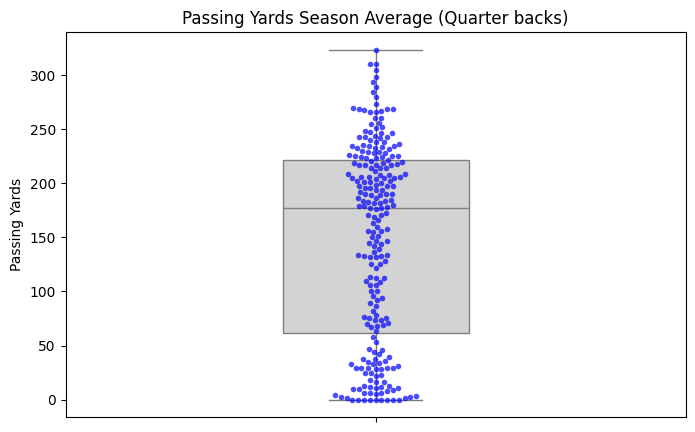

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(data=qb, y="passing_yards", color="lightgray", width=0.3)
sns.swarmplot(data=qb, y="passing_yards", color="blue", size=4, alpha=0.7)
plt.title("Passing Yards Season Average (Quarter backs)")
plt.ylabel("Passing Yards")
plt.xlabel("")
plt.show()

Running back Rushing Yards

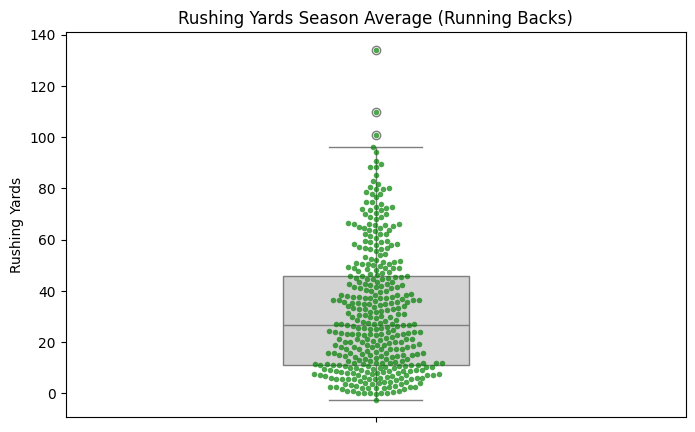

In [37]:
plt.figure(figsize=(8,5))
sns.boxplot(data=rb, y="rushing_yards", color="lightgray", width=0.3)
sns.swarmplot(data=rb, y="rushing_yards", color="green", size=4, alpha=0.7)
plt.title("Rushing Yards Season Average (Running Backs)")
plt.ylabel("Rushing Yards")
plt.xlabel("")
plt.show()

Wide receiver Reception Yards

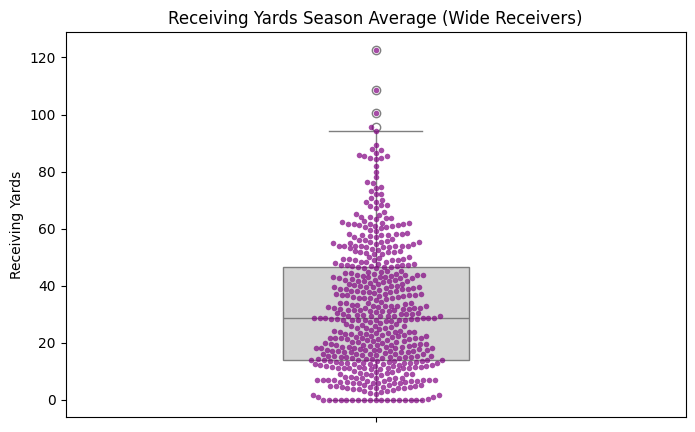

In [40]:
plt.figure(figsize=(8,5))
sns.boxplot(data=wr, y="receiving_yards", color="lightgray", width=0.3)
sns.swarmplot(data=wr, y="receiving_yards", color="purple", size=4, alpha=0.7)
plt.title("Receiving Yards Season Average (Wide Receivers)")
plt.ylabel("Receiving Yards")
plt.xlabel("")
plt.show()

Summary

As it can be seen, the highest yards for wide receivers are around the 100 yards a game per season, while the highest yards for quarterbacks are around the 300 yards a game per season. This is a way to show the massive difference between the yards completed for each position. One thing we notice, however, is that the distribution for quarter backs average yards a game per season is different than running backs and wide receivers, who share a similar shape.

### Correlation Analysis

In order to evaluate the correlation between the key statistics yards a game per season for each position, we can visualize the relationship to identify linearity. We can then conduct a Pearson correlation test, a parametric hypothesis test for evaluating the linear association between two variables (in our case, the key statistic and the contract value).

The idea is to evaluate what key statistic is most closely correlated with the value of the contract to see which positions key-statistic is the most market-influenced, and also evaluate which key metric is statistically associated with the value of a players first contract. by quantifying the strength of the relationship, we can observe how much variation in contract value each positions statistic can explain.

Quarter back Correlation

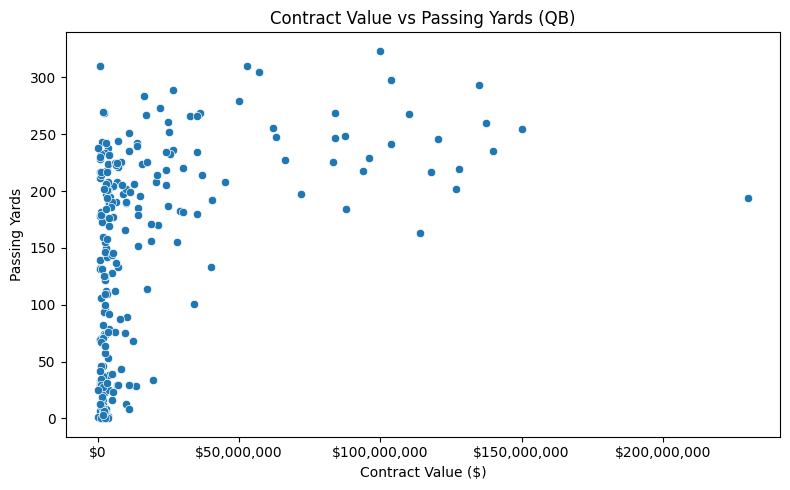

In [61]:
import matplotlib.ticker as mtick

plt.figure(figsize=(8, 5))
sns.scatterplot(data=qb, x="value", y="passing_yards")

plt.title("Contract Value vs Passing Yards (QB)")
plt.xlabel("Contract Value ($)")
plt.ylabel("Passing Yards")

fmt = '${:,.0f}'.format
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: fmt(x)))

plt.tight_layout()
plt.show()


Running back Correlation

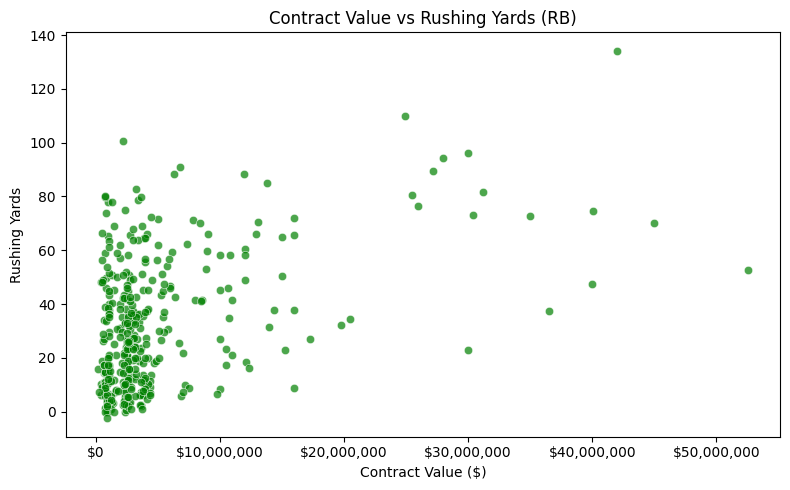

In [64]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=rb, x="value", y="rushing_yards", color="green", alpha=0.7)

plt.title("Contract Value vs Rushing Yards (RB)")
plt.xlabel("Contract Value ($)")
plt.ylabel("Rushing Yards")

fmt = '${:,.0f}'.format
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: fmt(x)))

plt.tight_layout()
plt.show()


Wide receiver Correlation

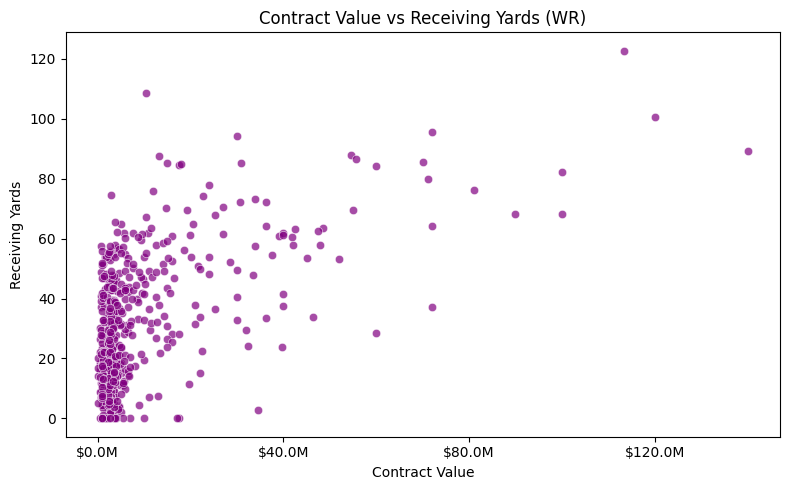

In [79]:
def fmt_millions(x, pos):
    return f'${x*1e-6:.1f}M'

plt.figure(figsize=(8, 5))
sns.scatterplot(data=wr, x="value", y="receiving_yards", color="purple", alpha=0.7)

plt.title("Contract Value vs Receiving Yards (WR)")
plt.xlabel("Contract Value")
plt.ylabel("Receiving Yards")

ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FuncFormatter(fmt_millions))

ax.xaxis.set_major_locator(mtick.MaxNLocator(5))

plt.tight_layout()
plt.show()


Interestingly, we see how the running back and wide receiver key-statistics against contract value follow more linearity than the quarter back comparison. There is a prominent vertical line with quarter backs, where the more the contract is valued at does not automatically mean that the player will be completing more yards. While less evident, this trends seems to follow (at least visually) to the other correlation graphics. We quantify this relationship in order to properly compare it. Additionally, we opt to evaluate whether the key-statistic on-field performance is associated with the monetary value of a player's first season on a team's contract. We can do this through a Pearson correlation test, which measures linear relationships between two continuous variables.

Correlation Metrics

In [82]:
from scipy.stats import pearsonr
import pandas as pd

results = []

# QB
qb_clean = qb[['passing_yards', 'value']].dropna()
r, p = pearsonr(qb_clean['passing_yards'], qb_clean['value'])
results.append(["QB", "Passing Yards", len(qb_clean), r, p])

# RB
rb_clean = rb[['rushing_yards', 'value']].dropna()
r, p = pearsonr(rb_clean['rushing_yards'], rb_clean['value'])
results.append(["RB", "Rushing Yards", len(rb_clean), r, p])

# WR
wr_clean = wr[['receiving_yards', 'value']].dropna()
r, p = pearsonr(wr_clean['receiving_yards'], wr_clean['value'])
results.append(["WR", "Receiving Yards", len(wr_clean), r, p])

results_df = pd.DataFrame(results, columns=[
    "Position",
    "Performance Variable",
    "Sample Size (n)",
    "Correlation (r)",
    "p-value"
])

results_df


,Position,Performance Variable,Sample Size (n),Correlation (r),p-value
0,QB,Passing Yards,232,0.433392,4.846955e-12
1,RB,Rushing Yards,372,0.436313,1.013998e-18
2,WR,Receiving Yards,499,0.566733,9.736644e-44


Assuming that the null hypothesis to be that there is no linear association between a player's performance metric and the value of their contract, and the alternative hypothesis to be that there is an association, we can reject the null hypothesis on all three positions, as the p-value is below any reasonable significance level. We conclude that there is a statistically significant association between each positions key statistic and the monetary value. 

However, evaluating the correlation value specifically, we can see how wide receiver's receiving yards show a strong relationship, as receiving yard explains more variation in a wide receiver's contract than the quarter back and running backs result. However, while the relationship is strong, running backs and quarter backs still show a moderate relationship, as their key-metrics can explain around 43% of the variance in each positions contract.

## Wildcard Analysis

Inspired by the movie "Moneyball", which is based on a data-analyst introducing the importance on focusing of under looked metrics through data, we decided to ask the following question: While the key-metrics are the most important for each position, are they necessarily the ones that have the strongest association with the contract value?

In order to clarify this question, we can manually inspect the variables that are in the dataset, and try to separate them into the relevant positions (as for example, any receiving related metric wont be relevant to QBs, and arguably may be somewhat relevant for RBs, but this would be more of an exception)

In [85]:
for col in pl.columns:
    print(col)

player_name
season
pass_attempts
complete_pass
incomplete_pass
passing_yards
receiving_yards
yards_after_catch
rush_attempts
rushing_yards
first_down_pass
first_down_rush
third_down_converted
third_down_failed
pass_touchdown
interception
receptions
targets
passing_air_yards
receiving_air_yards
receiving_touchdown
pass_attempts_redzone
complete_pass_redzone
receptions_redzone
targets_redzone
receiving_touchdown_redzone
rush_attempts_redzone
fantasy_points_ppr
fantasy_points_standard
passer_rating
adot
comp_pct
ypa
rec_td_pct
yptarget
ayptarget
ypr
ypc
touches
total_tds
td_pct
total_yards
yptouch
years_exp
team_targets_share
team_receptions_share
team_receiving_yards_share
team_receiving_air_yards_share
team_receiving_touchdown_share
team_rush_attempts_share
team_rushing_yards_share
age
draft_ovr
draft_pick
draft_round
draft_year
height
offense_snaps
weight
college
conference
division
player_id
position
team
player
year_signed
value
value_norm
gtd
gtd_norm


We decide to designate the statistics to each position, based on relevance and exploring the most common metrics for each position through reliable websites like ESPN

In [88]:
# QB special stats
qb_stats = [
    'passing_yards', 'pass_attempts', 'complete_pass', 'incomplete_pass',
    'pass_touchdown', 'interception', 'passing_air_yards', 'passer_rating',
    'ypa', 'comp_pct', 'td_pct'
]

qb_special = qb[['value'] + [c for c in qb_stats if c in qb.columns]].copy()


# RB special stats
rb_stats = [
    'rushing_yards', 'rush_attempts', 'first_down_rush',
    'rushing_touchdown', 'ypc', 'team_rush_attempts_share'
]

rb_special = rb[['value'] + [c for c in rb_stats if c in rb.columns]].copy()


# WR special stats
wr_stats = [
    'receiving_yards', 'receptions', 'targets', 'receiving_air_yards',
    'receiving_touchdown', 'rec_td_pct', 'adot', 'yptarget', 'ayptarget',
    'team_targets_share', 'team_receptions_share',
    'team_receiving_yards_share', 'team_receiving_touchdown_share'
]

wr_special = wr[['value'] + [c for c in wr_stats if c in wr.columns]].copy()


We can now generate the 3 top highest correlated metrics for each position. While we might be able to see the key-statistics as before belong to the 3 highest correlated metrics, this can help us understand better how key statistics are ranked on correlation with contract value against other less considered metrics

In [106]:
def run_moneyball(position_name, df):
    results = []
    
    for col in df.columns:
        if col == 'value': 
            continue
        temp = df[['value', col]].dropna()
        
        if temp.empty:
            continue
        
        r, p = pearsonr(temp['value'], temp[col])
        results.append([position_name, col, len(temp), r, p])
    
    res_df = pd.DataFrame(results, columns=[
        "Position", "Stat", "n", "Correlation (r)", "p-value"
    ])
    
    res_df['abs_r'] = res_df['Correlation (r)'].abs()
    return res_df.sort_values('abs_r', ascending=False).drop(columns='abs_r')

qb_results = run_moneyball("QB", qb_special)
rb_results = run_moneyball("RB", rb_special)
wr_results = run_moneyball("WR", wr_special)

qb_top3 = qb_results.head(3)
rb_top3 = rb_results.head(3)
wr_top3 = wr_results.head(3)



In [115]:
from IPython.display import display, Markdown

display(Markdown("### Top 3 QB Predictors of Contract Value"))
qb_top3

### Top 3 QB Predictors of Contract Value

,Position,Stat,n,Correlation (r),p-value
4,QB,pass_touchdown,232,0.441464,1.744329e-12
0,QB,passing_yards,232,0.433392,4.846955e-12
2,QB,complete_pass,232,0.414864,4.579737e-11


In [121]:
display(Markdown("### Top 3 RB Predictors of Contract Value"))
rb_top3

### Top 3 RB Predictors of Contract Value

,Position,Stat,n,Correlation (r),p-value
1,RB,rush_attempts,372,0.438962,5.930080e-19
0,RB,rushing_yards,372,0.436313,1.013998e-18
2,RB,first_down_rush,372,0.387195,9.404050e-15


In [124]:
display(Markdown("### Top 3 WR Predictors of Contract Value"))
wr_top3

### Top 3 WR Predictors of Contract Value

,Position,Stat,n,Correlation (r),p-value
0,WR,receiving_yards,499,0.566733,9.736644e-44
2,WR,targets,499,0.538145,8.298887e-39
3,WR,receiving_air_yards,499,0.526141,7.116953e-37


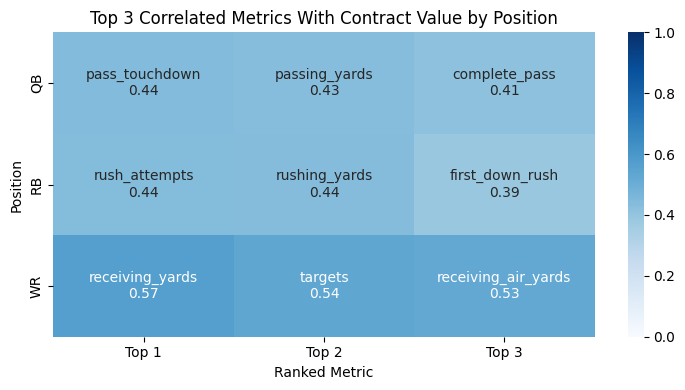

In [154]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

corr_vals = np.array([
    qb_top3["Correlation (r)"].values,
    rb_top3["Correlation (r)"].values,
    wr_top3["Correlation (r)"].values
])

corr_grid = pd.DataFrame(
    corr_vals,
    index=["QB", "RB", "WR"],
    columns=["Top 1", "Top 2", "Top 3"]
)


labels = np.empty_like(corr_vals, dtype=object)

for i, top3 in enumerate([qb_top3, rb_top3, wr_top3]):
    for j in range(3):
        stat = top3["Stat"].iloc[j]
        r = top3["Correlation (r)"].iloc[j]
        labels[i, j] = f"{stat}\n{r:.2f}"

plt.figure(figsize=(7.5, 4))
sns.heatmap(
    corr_grid,
    annot=labels,
    fmt="",
    cmap="Blues",
    vmin=0,
    vmax=1
)

plt.title("Top 3 Correlated Metrics With Contract Value by Position")
plt.xlabel("Ranked Metric")
plt.ylabel("Position")
plt.tight_layout()
plt.show()



Several concepts can be explored through these results. Firstly, the original metrics we evaluated as most important are present, but they present a different result for each position. Firstly, for the QB and RB positions, the original metrics are the second highest correlation value, being slightly over passed by other metrics.

For QB, we notice how passing touchdowns are a stronger predictor of contract value, which can be understood through the lower frequency of this metric for players who aren't "top players" (as quarterbacks will have a large variation of passing yards per game, but only the best quarterbacks are able to do passing touchdowns consistently.

Then, for running backs, we see how rushing attempts is a better predictor (slightly) than rushing yards. This can be explained by how players who are payed more can often be more confident, so they are trusted more by their quarter back, regardless of their performance. 

Finally, we see how receiving yards is the most important predictor of contract value, however it is preceded by targets, which is surprising, as we would have expected for targets to be more common for star players or players with a more expensive contract.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bf22fa5b-7fcf-43fa-8b0f-f5d91632bd98' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>